# Simulacion de distribuciones por radio censal

**A continuación se detalla:**

1. Estimación del total de viviendas/hogares por categorías a partir del total registrado en el Precenso 2020.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

In [3]:
from datasources import (
    tipoviv_radios_prov,
    radios_prov,
    radios_precenso_2020,
    radios_eph_censo_2010,
)

2023-05-19 12:45:55.615 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-19 12:45:55.616 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-19 12:45:55.618 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-19 12:45:55.619 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-19 12:45:55.620 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-19 12:45:55.621 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [4]:
from modeling_tools import (
    tracts_2020_to_2010,
    tracts_2010_to_2001,
    simulate_cat_var
)

In [5]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx='12')
corrientes_2001 = radios_prov(year=2001, prov='corrientes', mask=envolvente)
corrientes_2010 = radios_prov(year=2010, prov='corrientes', mask=envolvente)
corrientes_2020 = radios_precenso_2020(geo_filter={'prov':'18', 'depto':'021'}, mask=None)

In [6]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(year=2001, prov='corrientes',var_types={'LINK':'object'})
tipo_2001_geo = corrientes_2001.set_index('link').join(tipo_2001.set_index('link'))
tipo_2010 = tipoviv_radios_prov(year=2010, prov='corrientes',var_types={'link':'object'})
tipo_2010_geo = corrientes_2010.set_index('link').join(tipo_2010.set_index('link'))

In [7]:
corrientes_2020_ = tracts_2020_to_2010(tracts_2020_gdf=corrientes_2020, tracts_2010_gdf=corrientes_2010)

# Verifico que todos los radios 2020 cuenten con referencia 2010
corrientes_2020_['link_2010'].isna().unique()

# Radios 2020 con referencias 2010 y 2001
tracts_corrientes_2020 = tracts_2010_to_2001(tracts_2020_gdf=corrientes_2020_)

In [8]:
# Distribucion de categorias por radio censal
simulated_distribution = simulate_cat_var(gdf_var_01=tipo_2001_geo, 
                                          gdf_var_10=tipo_2010_geo,
                                          base_year='2010', forecast_year='2020',
                                          forecast_gdf=tracts_corrientes_2020, pct_val=2.5, 
                                          catname='casilla', tot_colname='total_viviendas')

tracts_corrientes_2020['casilla_2020'] = tracts_corrientes_2020['link'].map(simulated_distribution)

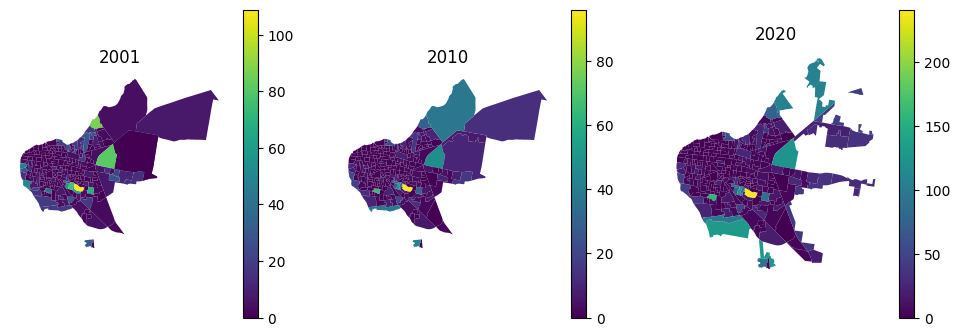

In [9]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(1,3,1)
ax2 = f.add_subplot(1,3,2)
ax3 = f.add_subplot(1,3,3)

tipo_2001_geo.plot(ax=ax1, column='casilla', legend=True, legend_kwds={'shrink': 0.5})
tipo_2010_geo.plot(ax=ax2, column='casilla', legend=True, legend_kwds={'shrink': 0.5})
tracts_corrientes_2020.plot(ax=ax3, column='casilla_2020', legend=True, legend_kwds={'shrink': 0.5})

ax1.set_title('2001')
ax1.set_axis_off()
ax2.set_title('2010')
ax2.set_axis_off()
ax3.set_title('2020')
ax3.set_axis_off();

In [10]:
# Con catname uso la distribucion de una variable en 2001 y de otra en 2010 en funcion del diccionario que pasamos como parametro
# TODO: Para mezclar categorias de distintos dataframes (por ejemplo, 'recoleccion de basura en 2001' y 'rancho en 2010') habria
# que agregar las columnas deseadas tanto en gdf_var_01 o gdf_var_10.
simulated_distribution = simulate_cat_var(gdf_var_01=tipo_2001_geo, 
                                          gdf_var_10=tipo_2010_geo,
                                          base_year='0110', forecast_year='2020',
                                          forecast_gdf=tracts_corrientes_2020, pct_val=2.5, 
                                          catname={'2001':'casilla', '2010':'rancho'}, 
                                          tot_colname='total_viviendas')

tracts_corrientes_2020['informal_2020'] = tracts_corrientes_2020['link'].map(simulated_distribution)

In [11]:
tracts_corrientes_2020['informal_2020'].sum()

3412.0

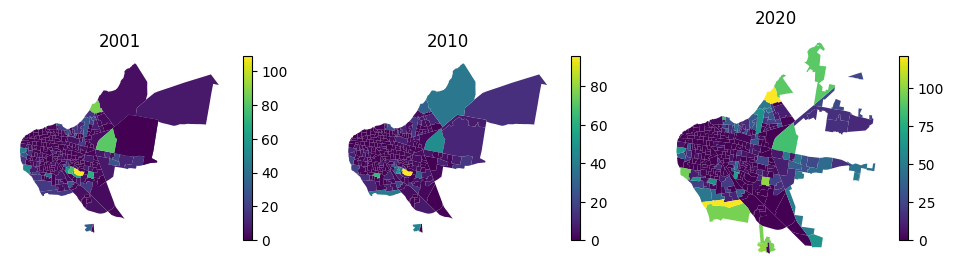

In [12]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(1,3,1)
ax2 = f.add_subplot(1,3,2)
ax3 = f.add_subplot(1,3,3)

tipo_2001_geo.plot(ax=ax1, column='casilla', legend=True, legend_kwds={'shrink': 0.3})
tipo_2010_geo.plot(ax=ax2, column='casilla', legend=True, legend_kwds={'shrink': 0.3})
tracts_corrientes_2020.plot(ax=ax3, column='informal_2020', legend=True, legend_kwds={'shrink': 0.3})

ax1.set_title('2001')
ax1.set_axis_off()
ax2.set_title('2010')
ax2.set_axis_off()
ax3.set_title('2020')
ax3.set_axis_off();